In [1]:

import highway_env
import numpy as np
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T    
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
config = {
       "observation": {
           "type": "GrayscaleObservation",
           "observation_shape": (128, 64),
           "stack_size": 4,
           "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
           "scaling": 1.75,
       },
       "policy_frequency": 2
   }

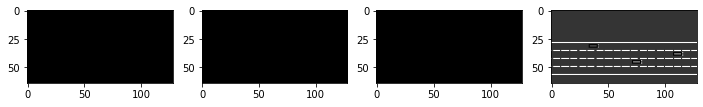

In [4]:
env = gym.make('highway-v0')
env.configure(config)
obs = env.reset()

_, axes = plt.subplots(ncols=4, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

<h1> Nueral Network Class</h1>

In [5]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.double()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=64)   
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=16)
        self.out = nn.Linear(in_features=16, out_features=5)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t

In [6]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [7]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

<h1> Exploration vs Exploitation Class</h1>

In [8]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)

In [9]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return random.randrange(self.num_actions) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).item() # exploit  

<h1> Environment Class</h1>

In [10]:
class highwayModel():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('highway-v0').unwrapped
        self.env.configure(config)
        self.env.reset()
        self.current_screen = None
        self.done = False
    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action)
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
#         top = int(screen_height * 0.2)
#         bottom = int(screen_height * 0.4)
#         screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

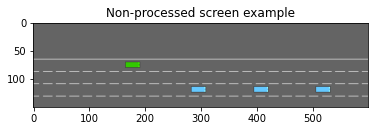

In [11]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
em = highwayModel(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

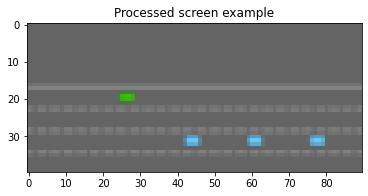

In [12]:
screen = em.render('rgb_array')
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

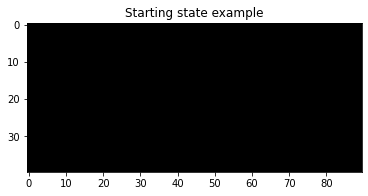

In [13]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


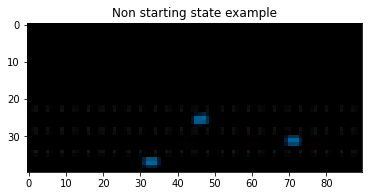

In [14]:
for i in range(5):
   em.take_action(1)
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

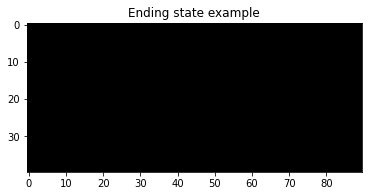

In [15]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [16]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [17]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    
    t2 = torch.tensor(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

<h1> Q Value Computation Class</h1>

In [18]:
class QValues():
    device = torch.device("cpu")
    @staticmethod
    def get_current(policy_net, states, actions):
#         print("action Size: ",actions.unsqueeze(-1).size())
#         print("state Size: ",policy_net(states).size())
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [19]:
def plot(values, moving_avg_period,loss,num_of_epi_epi):
    plt.figure(2)
    plt.clf()        
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    data="Moving avg:"+ str(moving_avg[-1])
    #print("Mo",moving_avg)
    plt.title(data)
    plt.plot(moving_avg)    
    plt.savefig('result_img.png')
    #plt.pause(0.001)
    
    plt.clf() 
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(num_of_epi_epi,loss)
    #plt.pause(0.001)
    plt.savefig('loss_img.png')
    if(len(loss)>1):
        print("Loss : ",loss[-1])
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [20]:
batch_size = 100
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.0000001
num_episodes = 350

In [21]:
device = torch.device("cpu")

In [22]:
em = highwayModel(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [23]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [24]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [25]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=5, bias=True)
)

In [26]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [27]:
episode_durations = []

In [28]:
loss_val=[]
num_of_epi=[]

<h1> Main Algorithm</h1>

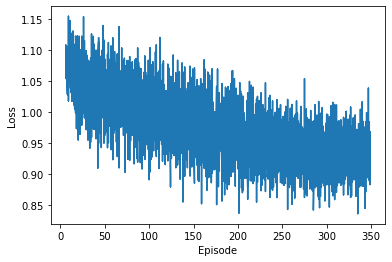

In [29]:
for episode in range(num_episodes):
    
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = agent.select_action(state, policy_net)
        #print("state:  ",state.size())
        #print(policy_net(state).size())
        reward = em.take_action(action)
        
        next_state = em.get_state()
        
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
        
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            #print("States before policy: ",states.size())
            #print("actions: ",actions.size())
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            

            loss = F.mse_loss(current_q_values.float(), target_q_values.unsqueeze(1).float())
            loss_val.append(loss.item())
            num_of_epi.append(episode)
            #printd(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #break

        if em.done:
            
            episode_durations.append(timestep)
            plot(episode_durations, 100,loss_val,num_of_epi)
            break
    #print("loss:", loss)
    #print("Num of episode: ", loss_graph)
    
    #break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()